In [5]:
# Refrence form: https://app.readytensor.ai/publications/music-composer-classification-of-midi-files-using-deep-learning-qZ9m02sVKl8C

import os
import numpy as np
import pandas as pd
import pretty_midi
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [6]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

<b>Feature Extraction Function</b>

In [7]:
def extract_features(midi_path):
    # Load the MIDI file using pretty_midi
    midi = pretty_midi.PrettyMIDI(midi_path)

    # Estimate the overall tempo (beats per minute)
    tempo = midi.estimate_tempo()
    
    # Collect all notes from non-drum instruments
    notes = []
    for inst in midi.instruments:
        if not inst.is_drum:
            notes.extend(inst.notes)
    if not notes:
        return None
    
    # Sort notes by their start time
    notes = sorted(notes, key=lambda x: x.start)

    # Calculate the total duration of the piece
    duration = midi.get_end_time()

     # Note density: number of notes per second
    note_density = len(notes) / duration if duration > 0 else 0

     # Pitch variance: how spread out the pitches are
    pitches = np.array([note.pitch for note in notes])
    pitch_variance = np.var(pitches)

    # Velocity features: how hard notes are played
    velocities = np.array([note.velocity for note in notes])
    velocity_mean = np.mean(velocities)
    velocity_max = np.max(velocities)
    velocity_var = np.var(velocities)

     # Polyphony: average number of notes sounding at the same time
    fs = 100
    piano_roll = midi.get_piano_roll(fs=fs)
    polyphony = np.mean(np.sum(piano_roll > 0, axis=0))

    # Rhythmic density: similar to note density (could later be refined)
    rhythmic_density = len(notes) / duration if duration > 0 else 0

    # Average pitch interval: average jump between consecutive notes
    pitch_intervals = np.abs(np.diff(pitches))
    avg_pitch_interval = np.mean(pitch_intervals) if len(pitch_intervals) > 0 else 0

    # Chord density: proportion of notes that start almost at the same time (within 50 ms)
    chord_counts = sum(1 for i in range(len(notes)-1) if abs(notes[i+1].start - notes[i].start) < 0.05)
    chord_density = chord_counts / len(notes)

    # Pitch transitions: ratio of changes in pitch from one note to the next
    pitch_transitions = np.sum(pitches[1:] != pitches[:-1]) / len(pitches) if len(pitches) > 1 else 0
    
     # Average note duration
    durations = np.array([note.end - note.start for note in notes])
    avg_note_duration = np.mean(durations)
    
     # Number of instruments used
    num_instrument = len(midi.instruments)
    
    return {
        "tempo": tempo,
        "note_density": note_density,
        "pitch_variance": pitch_variance,
        "velocity_mean": velocity_mean,
        "velocity_max": velocity_max,
        "velocity_variance": velocity_var,
        "polyphony": polyphony,
        "rhythmic_density": rhythmic_density,
        "avg_pitch_interval": avg_pitch_interval,
        "chord_density": chord_density,
        "pitch_transitions": pitch_transitions,
        "avg_note_duration": avg_note_duration,
        "num_instrument": num_instrument
    }

<b>Extract the features from the files </b>

In [8]:
# Initialize empty lists to store features and corresponding labels
data = []
labels = []

# Define the dataset splits (train and test)
split_dr = ['train', 'test']

# Loop through each split (train/test folders) and process the MIDI files
for split in split_dr:
    split_path = os.path.join('musicData', split)
    for composer in os.listdir(split_path):
        if composer.endswith(".DS_Store"):
            continue
        composer_path = os.path.join(split_path, composer)
        for file in os.listdir(composer_path):
            if file.endswith(".DS_Store"):
                continue
            if file.endswith('.mid'):
                file_path = os.path.join(composer_path, file)
                 # Extract features from the MIDI file
                features = extract_features(file_path)
                if features is not None:
                    data.append(features)
                    labels.append(composer)

# Convert to DataFrame
df = pd.DataFrame(data)
df['composer'] = labels

<b>Tempo DIstribution</b>

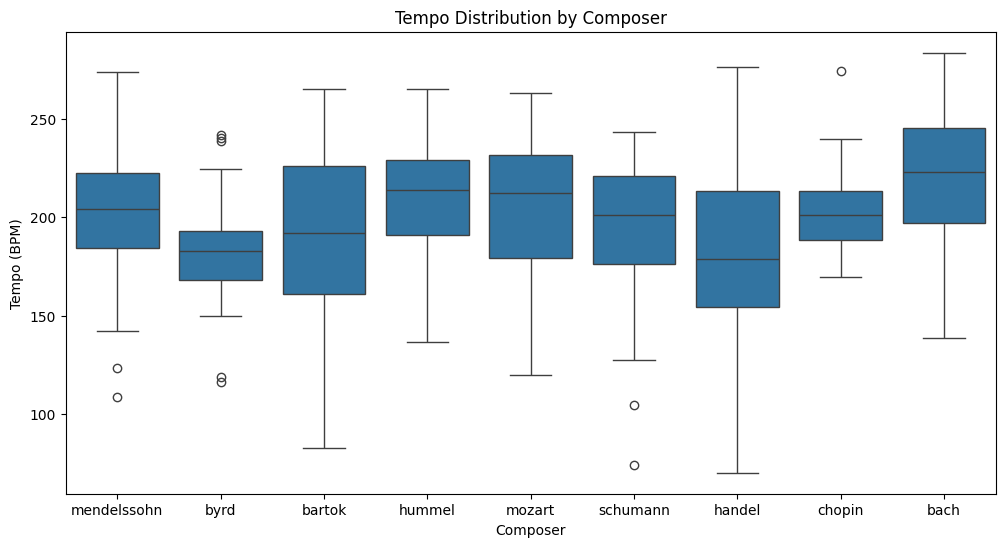

In [9]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='composer', y='tempo', data=df)
plt.title('Tempo Distribution by Composer')
plt.ylabel('Tempo (BPM)')
plt.xlabel('Composer')
plt.show()

<b>Note Velocity Distribution</b>

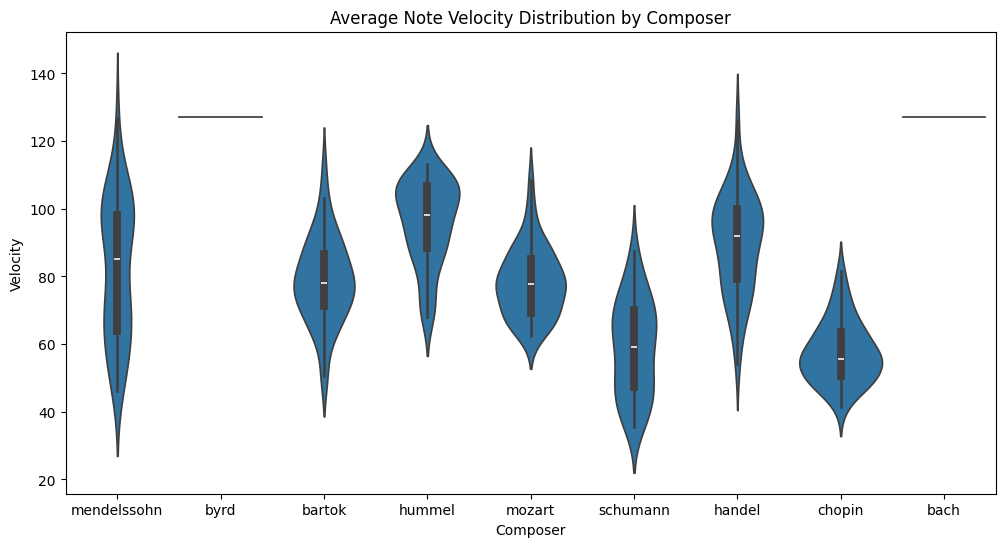

In [10]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='composer', y='velocity_mean', data=df)
plt.title('Average Note Velocity Distribution by Composer')
plt.ylabel('Velocity')
plt.xlabel('Composer')
plt.show()

<b>Number of Instruments and Average Velocity </b>

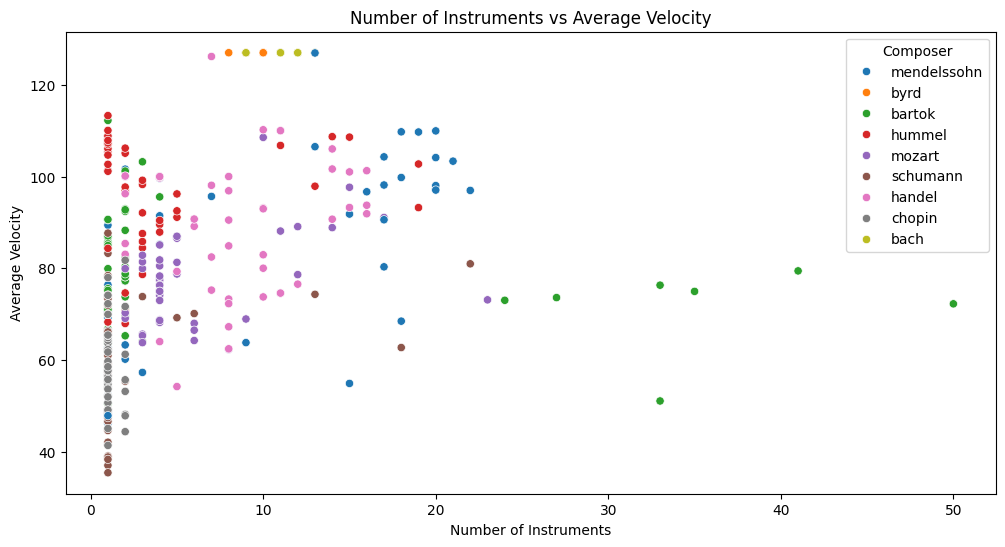

In [11]:
plt.figure(figsize=(12, 6))
sns.scatterplot(x='num_instrument', y='velocity_mean', hue='composer', data=df)
plt.title('Number of Instruments vs Average Velocity')
plt.ylabel('Average Velocity')
plt.xlabel('Number of Instruments')
plt.legend(title='Composer')
plt.show()

<b>Composers Class Distribution</b>

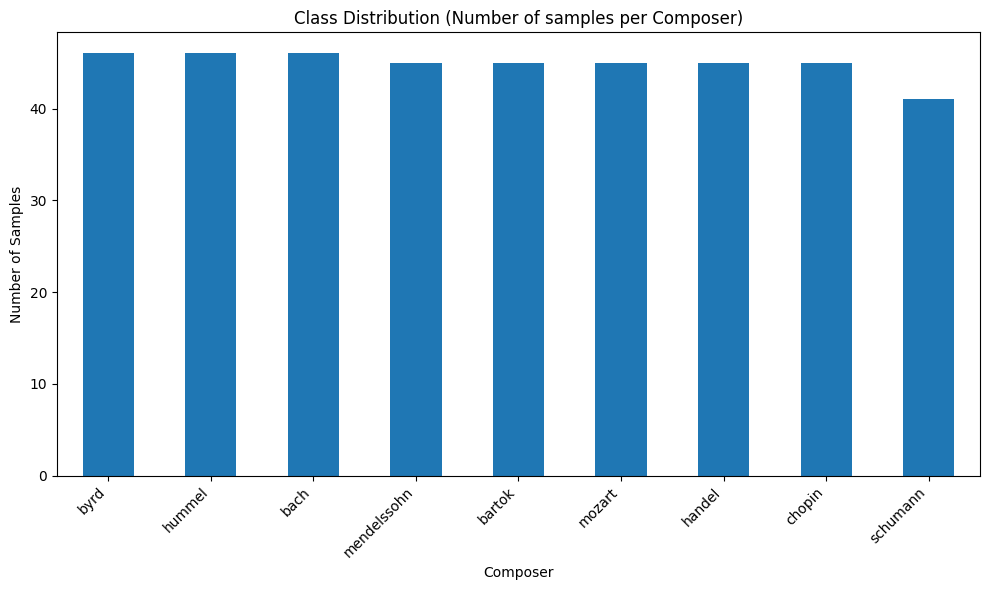

In [12]:
# Count samples per composer
class_counts = df['composer'].value_counts()

# Plot bar chart
plt.figure(figsize=(10,6))
class_counts.plot(kind='bar')
plt.title('Class Distribution (Number of samples per Composer)')
plt.xlabel('Composer')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

<b>Encoding</b>

In [13]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['composer'])

# Separate features and scale them
X = df.drop('composer', axis=1).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

<b>Creating Sequence</b>

In [14]:
# Create sequences for LSTM (sequence length = 5)
seq_length = 10
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length + 1):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length-1])  # label of last timestep in sequence
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y, seq_length)


<b>Train and Test Split </b>

In [15]:
# Train-test split with stratification
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq
)

<b>One Hot Encoding</b>

In [16]:
# One-hot encode targets
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train_seq, num_classes)
y_test_cat = to_categorical(y_test_seq, num_classes)

<b>Model</b>

In [28]:
# Define model
input_shape = (X_train_seq.shape[1], X_train_seq.shape[2])
model = Sequential([
    LSTM(15, return_sequences=True, input_shape=input_shape, recurrent_dropout=0.4),
    Dropout(0.2),
    BatchNormalization(),
    LSTM(5, recurrent_dropout=0.5),
    BatchNormalization(),
    Dense(num_classes, activation='softmax')
])

# Compile Model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)

# Train model
history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=300,
    batch_size=32,
    callbacks=[early_stop, lr_reduce]
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test_seq, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.1296 - loss: 2.3984 - val_accuracy: 0.3038 - val_loss: 2.1384 - learning_rate: 0.0010
Epoch 2/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1984 - loss: 2.2375 - val_accuracy: 0.3291 - val_loss: 2.1049 - learning_rate: 0.0010
Epoch 3/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2942 - loss: 2.0462 - val_accuracy: 0.4304 - val_loss: 2.0705 - learning_rate: 0.0010
Epoch 4/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3252 - loss: 1.8731 - val_accuracy: 0.4304 - val_loss: 2.0352 - learning_rate: 0.0010
Epoch 5/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4081 - loss: 1.7710 - val_accuracy: 0.5190 - val_loss: 2.0005 - learning_rate: 0.0010
Epoch 6/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4691 - loss: 1.6847 - val_accuracy: 0.5316 - val_loss: 1.9655 - learning_rate: 0.0010
Epoch 7/300
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5117 - loss: 1.5629 - 

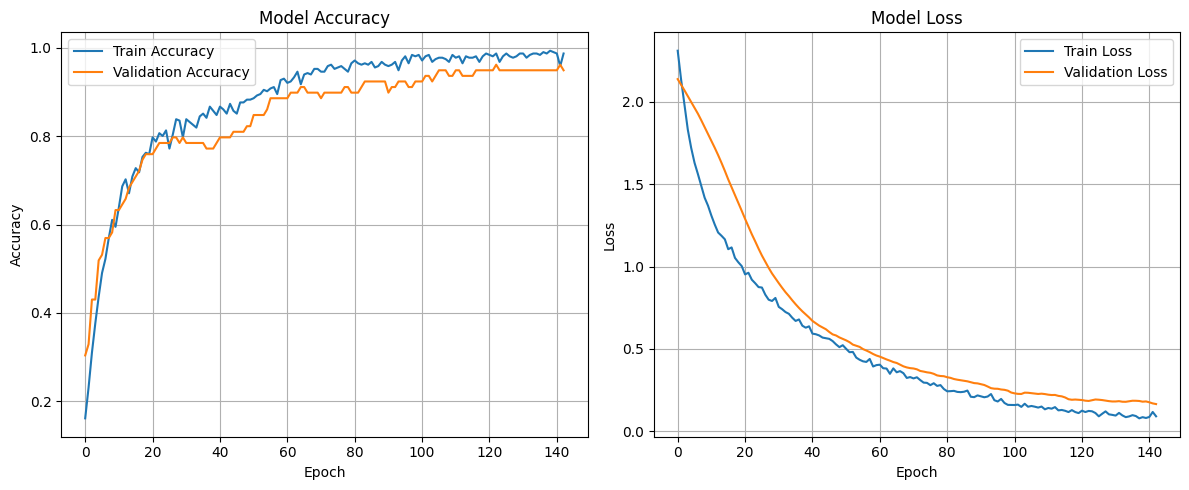

In [29]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

<b>Reprot</b>

In [30]:
from sklearn.metrics import classification_report
import numpy as np

# Predict class probabilities
y_pred_probs = model.predict(X_test_seq)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels (already integer encoded)
y_true = y_test_seq

# Print classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7fe239412fc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step
              precision    recall  f1-score   support

        bach       1.00      1.00      1.00         9
      bartok       0.90      1.00      0.95         9
        byrd       1.00      1.00     